# **Task-1: Random Forests & SVM with HOG feature Descriptor**
##Submitted by: Muhammad Jawad Bashir
##Reg No: 330295 (MSDS20)

### Loading google drive on colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Mounted at /content/gdrive
Google Drive is mounted



### SVM Classifier with HOG features

### Dataset loading....

In [3]:
# importing all the required modules
import cv2   # for loading and preprocessing the images
from sklearn import svm   # svm classifier from sklearn
from sklearn.ensemble import RandomForestClassifier  # random forest classifier
import os  # for handling files and directories
import numpy as np   # Fir performing mathematical operations on arrays
from sklearn.externals import joblib   # for saving and loading the model
from skimage.feature import hog   # hog features used for classification
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle    # for shuffling the dataset
import sys     # helper functions
import random    # for randomly picking from list etc.,
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# dataset loading and preprocessing class
class DataLoader:
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    self.pos_img_path = os.path.join(self.dataset_path, "pos")
    self.neg_img_path = os.path.join(self.dataset_path, "neg")
  
  def read_filenames(self):
    for (dirpath, dirnames, filenames) in os.walk(self.pos_img_path):
        self.f_pos=filenames

    for (dirpath, dirnames, filenames) in os.walk(self.neg_img_path):
        self.f_neg=filenames

  def crop_centre(self, img):
    h, w, _ = img.shape
    l = (w - 64)//2
    t = (h - 128)//2

    crop = img[t:t+128, l:l+64]
    return crop

  def ten_random_windows(self, img):
    h, w = img.shape
    if h < 128 or w < 64:
        return []
    h = h - 128;
    w = w - 64
    windows = []

    for i in range(0, 10):
        x = random.randint(0, w)
        y = random.randint(0, h)
        windows.append(img[y:y+128, x:x+64])

    return windows

  def load_dataset(self, augment_negative=False):
    self.X, self.y = [], []
    self.pos_count, self.neg_count = 0,0
    print("Loading positive samples...")
    for img_file in self.f_pos:
      #print(os.path.join(self.pos_img_path, img_file))
      img = cv2.imread(os.path.join(self.pos_img_path, img_file))

      cropped = self.crop_centre(img)
# Implementing HOG...
      gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
      features = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2", transform_sqrt=True, feature_vector=True)
      self.pos_count += 1

      self.X.append(features)
      self.y.append(1)
    print("Loading negative samples...")
    for img_file in self.f_neg:
      #print(os.path.join(self.neg_img_path, img_file))
      img = cv2.imread(os.path.join(self.neg_img_path, img_file))
      if augment_negative:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        windows = self.ten_random_windows(gray_img)
        for win in windows:
          features = hog(win, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2", transform_sqrt=True, feature_vector=True)
          self.neg_count += 1
          self.X.append(features)
          self.y.append(0)
      else:
        cropped = self.crop_centre(img)
        gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2", transform_sqrt=True, feature_vector=True)
        self.X.append(features)
        self.y.append(0)
        self.neg_count += 1

    self.X = np.array(self.X)
    self.y = np.array(self.y)
    print("Shuffling the dataset...")
    self.X, self.y = shuffle(self.X, self.y, random_state=0)

### Defining the classifiers


In [5]:
### svm classifier
svm_clf = svm.LinearSVC(C=0.01, max_iter=1000, class_weight='balanced', verbose = 1)
### random forest classifier
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)

### Training

In [10]:
path = "/content/gdrive/MyDrive/INRIA_Dataset_Samples.zip (Unzipped Files)/Train"
data = DataLoader(path)
data.read_filenames()
data.load_dataset(augment_negative=True)

print("Images Read and Shuffled")
print("Positives: " + str(data.pos_count))
print("Negatives: " + str(data.neg_count))
print("Training Started")
svm_clf.fit(data.X, data.y)
joblib.dump(svm_clf, 'svm_clf.pkl')

random_forest_clf.fit(data.X, data.y)
joblib.dump(random_forest_clf, 'random_forest_clf.pkl')

Loading positive samples...
Loading negative samples...
Shuffling the dataset...
Images Read and Shuffled
Positives: 2416
Negatives: 12180
Training Started
[LibLinear]

['random_forest_clf.pkl']

### Loading test dataset

In [13]:
path = "/content/gdrive/MyDrive/INRIA_Dataset_Samples.zip (Unzipped Files)/Test"
test_data = DataLoader(path)
test_data.read_filenames()
test_data.load_dataset(augment_negative=False)

print("Images Read and Shuffled")
print("Positives: " + str(test_data.pos_count))
print("Negatives: " + str(test_data.neg_count))
print("Testing Started")

Loading positive samples...
Loading negative samples...
Shuffling the dataset...
Images Read and Shuffled
Positives: 1132
Negatives: 453
Testing Started


### Loading the classifiers

In [14]:
svm_clf = joblib.load('svm_clf.pkl')
rf_clf = joblib.load('random_forest_clf.pkl')

### Testing the models

SVM classifieer

In [15]:
y_pred_svm = svm_clf.predict(test_data.X)
c_mat = confusion_matrix(test_data.y, y_pred_svm)
print(c_mat)

false_positives = c_mat.sum(axis=0) - np.diag(c_mat)  
false_negatives = c_mat.sum(axis=1) - np.diag(c_mat)
true_positives = np.diag(c_mat)
true_negatives = c_mat.sum() - (false_positives + false_negatives + true_positives)
print(true_positives, false_positives, true_negatives, false_negatives)
# Sensitivity, hit rate, recall, or true positive rate
TPR = true_positives/(true_positives+false_negatives)
# Specificity or true negative rate
TNR = true_negatives/(true_negatives+false_positives) 
# Precision or positive predictive value
PPV = true_positives/(true_positives+false_positives)
# Negative predictive value
NPV = true_negatives/(true_negatives+false_negatives)
# Fall out or false positive rate
FPR = false_positives/(false_positives+true_negatives)
# False negative rate
FNR = false_negatives/(true_positives+false_negatives)
# False discovery rate
FDR = false_positives/(true_positives+false_positives)

# Overall accuracy
ACC = (true_positives+true_negatives)/(true_positives+false_positives+false_negatives+true_negatives)

print("true positive rate: ",TPR, "false positive rate: ",FPR)
print("Accuracy: ", ACC)

## Precision and recall and f-1 score for positive class
precision = float(true_positives[1]) / (true_positives[1] + false_positives[1])
recall = float(true_positives[1]) / (true_positives[1] + false_negatives[1])

f1 = 2*precision*recall / (precision + recall)

print ("Precision: " + str(precision), "Recall: " + str(recall))
print ("F1 Score: " + str(f1))

[[ 447    6]
 [  29 1103]]
[ 447 1103] [29  6] [1103  447] [ 6 29]
true positive rate:  [0.98675497 0.97438163] false positive rate:  [0.02561837 0.01324503]
Accuracy:  [0.97791798 0.97791798]
Precision: 0.9945897204688909 Recall: 0.9743816254416962
F1 Score: 0.9843819723337797


#### Visualization of results for svm classifier

Showing correct predictions...
[ 999 1507  746 1140  514 1206   16  982  332] [1583  405 1538  204 1384  721  853  881   19]


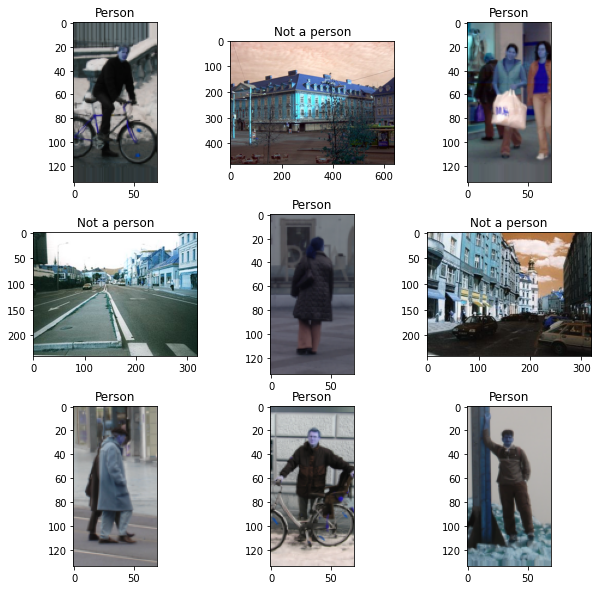



Showing wrong predictions....


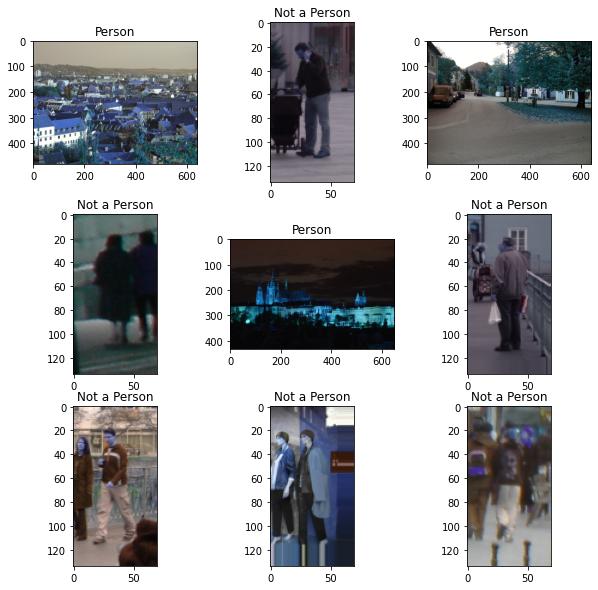

In [16]:
correct_preds = test_data.y == y_pred_svm
#print(type(test_data.y))
#print(sum(correct_preds), correct_preds[:10])
### Showing correct predictions
print("Showing correct predictions...")
correct_inds, incorrect_inds = [],[]
for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
#print(correct_inds, incorrect_inds)
correct_inds = np.random.choice(correct_inds, size=9)
incorrect_inds = np.random.choice(incorrect_inds, size=9)
print(correct_inds, incorrect_inds)

### plotting correct predictions
imgs, labels = [], []
for x in correct_inds:
  #print(x)
  if x < 1132:
    #print(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    d = cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #print(d.shape)
    imgs.append(cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x])))
    labels.append("Person")
  else:
    imgs.append(cv2.imread(os.path.join(test_data.dataset_path,"neg",test_data.f_neg[x-1132])))
    labels.append("Not a person")
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### plotting wrong predictions
print()
print()
print("Showing wrong predictions....")
imgs_, labels_ = [], []
for y in incorrect_inds:
  #print(x)
  if y < 1132:
    #print(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #d = cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #print(d.shape)
    imgs_.append(cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[y])))
    labels_.append("Not a Person")
  else:
    imgs_.append(cv2.imread(os.path.join(test_data.dataset_path,"neg",test_data.f_neg[y-1132])))
    labels_.append("Person")
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs_, axs, labels_):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### Random forest classifier

In [17]:
y_pred = rf_clf.predict(test_data.X)
c_mat = confusion_matrix(test_data.y, y_pred)
print(c_mat)

false_positives = c_mat.sum(axis=0) - np.diag(c_mat)  
false_negatives = c_mat.sum(axis=1) - np.diag(c_mat)
true_positives = np.diag(c_mat)
true_negatives = c_mat.sum() - (false_positives + false_negatives + true_positives)
print(true_positives, false_positives, true_negatives, false_negatives)
# Sensitivity, hit rate, recall, or true positive rate
TPR = true_positives/(true_positives+false_negatives)
# Specificity or true negative rate
TNR = true_negatives/(true_negatives+false_positives) 
# Precision or positive predictive value
PPV = true_positives/(true_positives+false_positives)
# Negative predictive value
NPV = true_negatives/(true_negatives+false_negatives)
# Fall out or false positive rate
FPR = false_positives/(false_positives+true_negatives)
# False negative rate
FNR = false_negatives/(true_positives+false_negatives)
# False discovery rate
FDR = false_positives/(true_positives+false_positives)

# Overall accuracy
ACC = (true_positives+true_negatives)/(true_positives+false_positives+false_negatives+true_negatives)

print("true positive rate: ",TPR, "false positive rate: ",FPR)
print("Accuracy: ", ACC)

## Precision and recall and f-1 score for positive class
precision = float(true_positives[1]) / (true_positives[1] + false_positives[1])
recall = float(true_positives[1]) / (true_positives[1] + false_negatives[1])

f1 = 2*precision*recall / (precision + recall)

print ("Precision: " + str(precision), "Recall: " + str(recall))
print ("F1 Score: " + str(f1))

[[453   0]
 [463 669]]
[453 669] [463   0] [669 453] [  0 463]
true positive rate:  [1.        0.5909894] false positive rate:  [0.4090106 0.       ]
Accuracy:  [0.70788644 0.70788644]
Precision: 1.0 Recall: 0.5909893992932862
F1 Score: 0.7429205996668518


### Visualization of results for random forest classifier

Showing correct predictions...
[ 828  893 1030  448  416 1085  630 1278   28] [ 536 1317  760 1260  806  947 1166 1228  374]


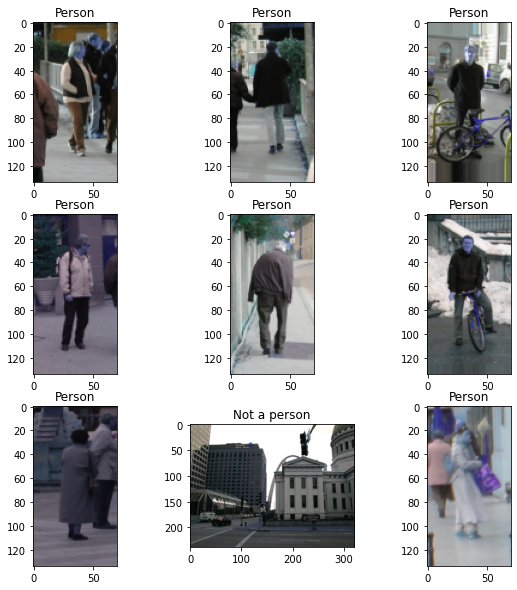



Showing wrong predictions....


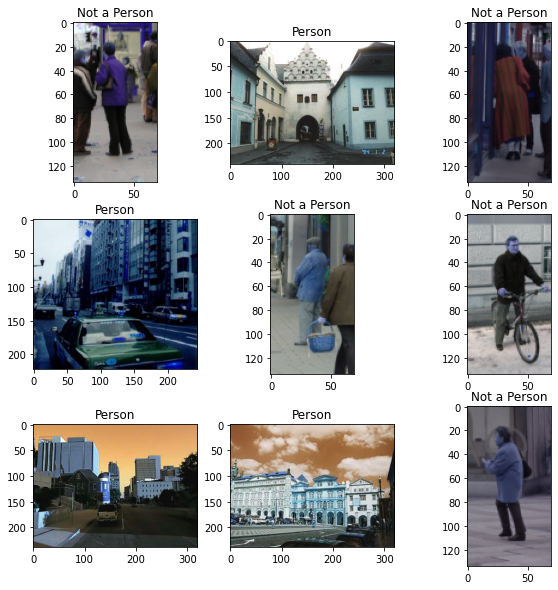

In [18]:
correct_preds = test_data.y == y_pred
#print(type(test_data.y))
#print(sum(correct_preds), correct_preds[:10])
### Showing correct predictions
print("Showing correct predictions...")
correct_inds, incorrect_inds = [],[]
for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
#print(correct_inds, incorrect_inds)
correct_inds = np.random.choice(correct_inds, size=9)
incorrect_inds = np.random.choice(incorrect_inds, size=9)
print(correct_inds, incorrect_inds)

### plotting correct predictions
imgs, labels = [], []
for x in correct_inds:
  #print(x)
  if x < 1132:
    #print(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    d = cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #print(d.shape)
    imgs.append(cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x])))
    labels.append("Person")
  else:
    imgs.append(cv2.imread(os.path.join(test_data.dataset_path,"neg",test_data.f_neg[x-1132])))
    labels.append("Not a person")
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

### plotting wrong predictions
print()
print()
print("Showing wrong predictions....")
imgs_, labels_ = [], []
for y in incorrect_inds:
  #print(x)
  if y < 1132:
    #print(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #d = cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[x]))
    #print(d.shape)
    imgs_.append(cv2.imread(os.path.join(test_data.dataset_path,"pos",test_data.f_pos[y])))
    labels_.append("Not a Person")
  else:
    imgs_.append(cv2.imread(os.path.join(test_data.dataset_path,"neg",test_data.f_neg[y-1132])))
    labels_.append("Person")
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs_, axs, labels_):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()